##Downloading the Dataset

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download kavyasreeb/hair-type-dataset

Dataset URL: https://www.kaggle.com/datasets/kavyasreeb/hair-type-dataset
License(s): apache-2.0
 99% 172M/175M [00:10<00:00, 23.4MB/s]
100% 175M/175M [00:10<00:00, 18.1MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/hair-type-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

##Importing necessary libraries

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16, ResNet50V2, InceptionResNetV2
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, Conv2D, Concatenate, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

##Data Preprocessing

In [6]:
dataset = "/content/data"
img_height = 224
img_width = 224
batch_size = 32
num_classes = 5

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    dataset,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    dataset,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation',
    shuffle=False
)

Found 1592 images belonging to 5 classes.
Found 395 images belonging to 5 classes.


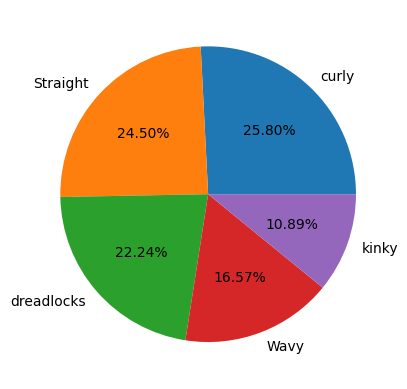

In [8]:
def create_df(path):
    dd = {"images": [], "labels": []}
    for i in os.listdir(path):
        styles = os.path.join(path, i)
        for j in os.listdir(styles):
            dd["images"].append(os.path.join(styles, j))
            dd["labels"].append(i)
    return pd.DataFrame(dd)

df = create_df(dataset)

df["labels"].value_counts().plot(kind="pie", autopct="%0.2f%%")
plt.xlabel("")
plt.ylabel("")
plt.show()

label_index = {"Straight": 0, "Wavy": 1, "curly": 2, "dreadlocks": 3, "kinky": 4}
index_label = {v: k for k, v in label_index.items()}

##VGG16

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
for layer in base_model.layers:
    layer.trainable = False
x = Dense(128, activation='relu')(base_model.output)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
output = Dense(len(train_generator.class_indices), activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
history = model.fit(train_generator, epochs=50, validation_data=val_generator, verbose=1)

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 45s 620ms/step - accuracy: 0.4172 - loss: 1.4149 - val_accuracy: 0.6785 - val_loss: 0.7720
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 264ms/step - accuracy: 0.7199 - loss: 0.7449 - val_accuracy: 0.6734 - val_loss: 0.7779
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 256ms/step - accuracy: 0.7635 - loss: 0.6302 - val_accuracy: 0.7038 - val_loss: 0.8079
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 265ms/step - accuracy: 0.8019 - loss: 0.5048 - val_accuracy: 0.7595 - val_loss: 0.6158
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 257ms/step - accuracy: 0.8158 - loss: 0.4748 - val_accuracy: 0.8051 - val_loss: 0.5234
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 259ms/step - accuracy: 0.8533 - loss: 0.4006 - val_accuracy: 0.7924 - val_loss: 0.5616
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 262ms/step - accuracy: 0.8651 - loss: 0.3408 - val_accuracy: 0.8025 - val_loss: 0.5835
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 289ms/step - accuracy: 0.8842 - loss: 0.3111 - val_accu

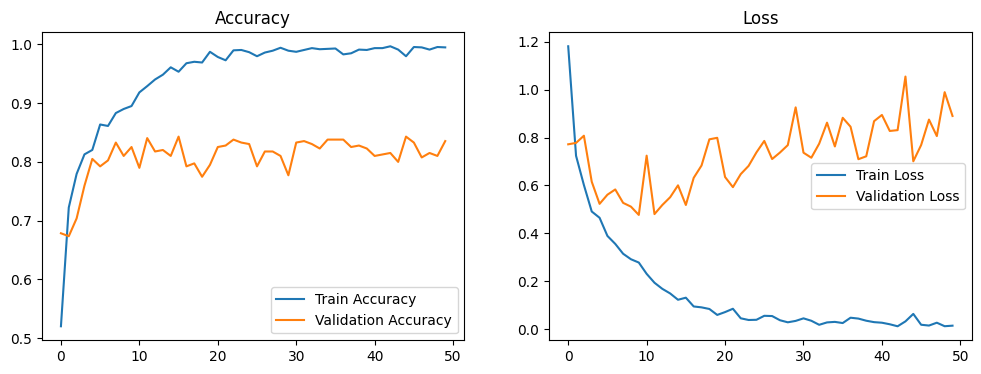

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

In [ ]:
val_generator.reset()
predictions = model.predict(val_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("\nClassification Report:\n")
print(report)

13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 336ms/step

Classification Report:

              precision    recall  f1-score   support

    Straight       0.83      0.89      0.86        97
        Wavy       0.79      0.83      0.81        65
       curly       0.88      0.85      0.87       102
  dreadlocks       0.83      0.91      0.87        88
       kinky       0.86      0.56      0.68        43

    accuracy                           0.84       395
   macro avg       0.84      0.81      0.82       395
weighted avg       0.84      0.84      0.83       395



In [ ]:
model.save('VGG16.keras')

##ResNet50V2

In [9]:
base_resnet = ResNet50V2(weights="imagenet", include_top=False, input_shape=(img_height, img_width, 3))
base_resnet.trainable = False

x = GlobalAveragePooling2D()(base_resnet.output)
x = Dense(5, activation="softmax")(x)

model1 = Model(inputs=base_resnet.input, outputs=x)

model1.compile(optimizer=Adam(learning_rate=0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [10]:
history1 = model1.fit(train_generator, epochs=25, validation_data=val_generator, verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 49s 660ms/step - accuracy: 0.3780 - loss: 1.4842 - val_accuracy: 0.6886 - val_loss: 0.8219
Epoch 2/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 253ms/step - accuracy: 0.7804 - loss: 0.6539 - val_accuracy: 0.7620 - val_loss: 0.6576
Epoch 3/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 254ms/step - accuracy: 0.8328 - loss: 0.5059 - val_accuracy: 0.7823 - val_loss: 0.5834
Epoch 4/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 249ms/step - accuracy: 0.8880 - loss: 0.3845 - val_accuracy: 0.7848 - val_loss: 0.5988
Epoch 5/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 253ms/step - accuracy: 0.9000 - loss: 0.3446 - val_accuracy: 0.8101 - val_loss: 0.5298
Epoch 6/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 247ms/step - accuracy: 0.8868 - loss: 0.3162 - val_accuracy: 0.8127 - val_loss: 0.5448
Epoch 7/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 260ms/step - accuracy: 0.9204 - loss: 0.2826 - val_accuracy: 0.8051 - val_loss: 0.5214
Epoch 8/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 246ms/step - accuracy: 0.9280 - loss: 0.2425 - val_accu

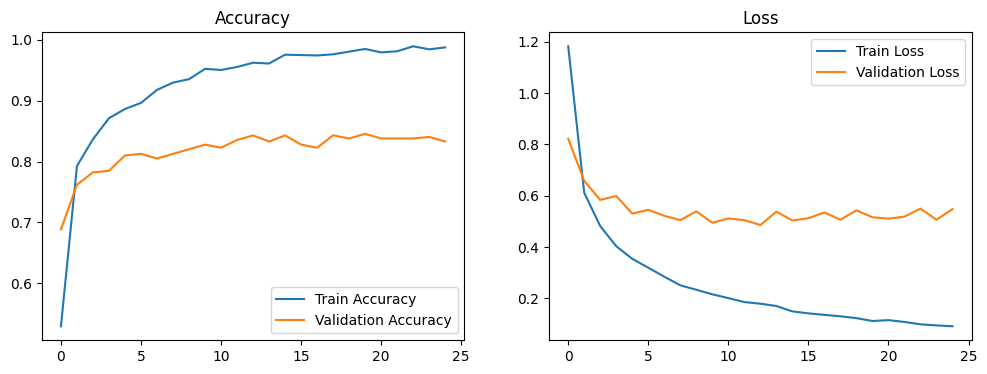

In [11]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='Train Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

In [13]:
model1.save('ResNet50V2.keras')

In [12]:
val_generator.reset()
predictions = model1.predict(val_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("\nClassification Report:\n")
print(report)

13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 591ms/step

Classification Report:

              precision    recall  f1-score   support

    Straight       0.81      0.94      0.87        97
        Wavy       0.84      0.63      0.72        65
       curly       0.83      0.91      0.87       102
  dreadlocks       0.91      0.85      0.88        88
       kinky       0.85      0.79      0.82        43

    accuracy                           0.85       395
   macro avg       0.85      0.82      0.83       395
weighted avg       0.85      0.85      0.84       395



##InceptionResNetV2

In [ ]:
base_densenet = InceptionResNetV2(weights="imagenet", include_top=False, input_shape=(img_height, img_width, 3))

base_densenet.trainable = False

x = GlobalAveragePooling2D()(base_densenet.output)
x = Dense(5, activation="softmax")(x)

model2 = Model(inputs=base_densenet.input, outputs=x)

model2.compile(optimizer=Adam(learning_rate=0.001), loss="sparse_categorical_crossentropy",metrics=["accuracy"])

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
history2 = model2.fit(train_generator, epochs=50, validation_data=val_generator, verbose=1)

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 71s 835ms/step - accuracy: 0.4429 - loss: 1.3793 - val_accuracy: 0.6532 - val_loss: 0.9890
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 250ms/step - accuracy: 0.6873 - loss: 0.8228 - val_accuracy: 0.7063 - val_loss: 0.8988
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 254ms/step - accuracy: 0.7450 - loss: 0.7034 - val_accuracy: 0.7392 - val_loss: 0.7467
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 257ms/step - accuracy: 0.7854 - loss: 0.6015 - val_accuracy: 0.7646 - val_loss: 0.6805
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 252ms/step - accuracy: 0.7731 - loss: 0.6043 - val_accuracy: 0.7620 - val_loss: 0.6517
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 253ms/step - accuracy: 0.8302 - loss: 0.5055 - val_accuracy: 0.7975 - val_loss: 0.6517
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 249ms/step - accuracy: 0.8288 - loss: 0.5083 - val_accuracy: 0.8000 - val_loss: 0.6091
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 252ms/step - accuracy: 0.8387 - loss: 0.4763 - val_accu

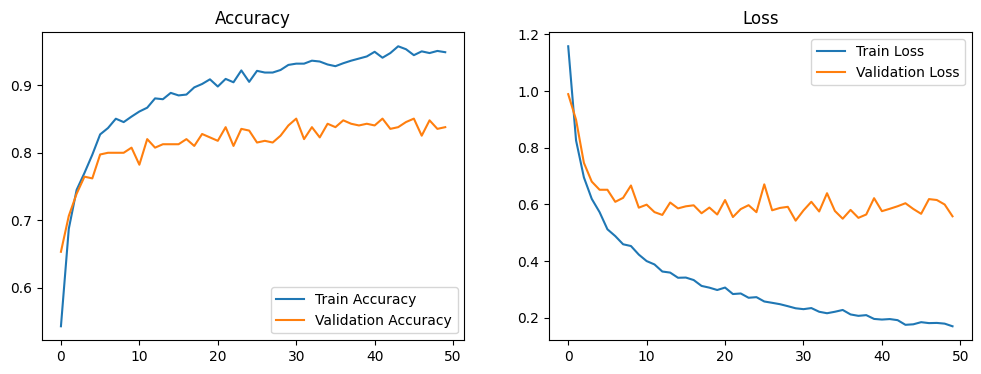

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

In [ ]:
val_generator.reset()
predictions = model2.predict(val_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("\nClassification Report:\n")
print(report)

13/13 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step

Classification Report:

              precision    recall  f1-score   support

    Straight       0.87      0.90      0.88        97
        Wavy       0.78      0.58      0.67        65
       curly       0.83      0.93      0.88       102
  dreadlocks       0.90      0.94      0.92        88
       kinky       0.77      0.70      0.73        43

    accuracy                           0.84       395
   macro avg       0.83      0.81      0.82       395
weighted avg       0.84      0.84      0.84       395



In [ ]:
model2.save('InceptionResNetV2.keras')

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp InceptionResNetV2.keras /content/drive/MyDrive/

In [ ]:
!cp VGG16.keras /content/drive/MyDrive/

In [15]:
!cp ResNet50V2.keras /content/drive/MyDrive/

##Ensemble Model

In [4]:
resnet50 = load_model("/content/drive/MyDrive/ResNet50V2.keras")
inception_resnet = load_model("/content/drive/MyDrive/InceptionResNetV2.keras")
vgg16 = load_model("/content/drive/MyDrive/VGG16.keras")

In [7]:
resnet50 = Model(inputs=resnet50.input, outputs=resnet50.layers[-2].output)
inception_resnet = Model(inputs=inception_resnet.input, outputs=inception_resnet.layers[-2].output)
vgg16 = Model(inputs=vgg16.input, outputs=vgg16.layers[-2].output)

input_shape = resnet50.input_shape[1:]
input_layer = Input(shape=input_shape)

resnet_output = resnet50(input_layer)
inception_output = inception_resnet(input_layer)
vgg_output = vgg16(input_layer)

resnet_output = GlobalAveragePooling2D()(resnet_output)
inception_output = GlobalAveragePooling2D()(inception_output)
vgg_output = GlobalAveragePooling2D()(vgg_output)

merged = Concatenate()([resnet_output, inception_output, vgg_output])

fc = Dense(512, activation='relu')(merged)
out = Dense(5, activation='softmax')(fc)

In [8]:
ensemble_model = Model(inputs=input_layer, outputs=out)
ensemble_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [9]:
ensemble_model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_6 (Functional) │ (None, 7, 7, 2048)     │     23,564,800 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_7 (Functional) │ (None, 5, 5, 1536)     │     54,336,736 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_8 (Functional) │ (None, 5, 5, 128)      │     14,927,936 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 2048)           │              0 │ functional_6[0][0]     │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 1536)           │              0 │ functional_7[0][0]     │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 128)            │              0 │ functional_8[0][0]     │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 3712)           │              0 │ global_average_poolin… │
│                           │                        │                │ global_average_poolin… │
│                           │                        │                │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 512)            │      1,901,056 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 5)              │          2,565 │ dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 94,733,093 (361.38 MB)

 Trainable params: 2,116,869 (8.08 MB)

 Non-trainable params: 92,616,224 (353.30 MB)

In [10]:
ensemble_model.save('ensemble_model.keras')

In [11]:
!cp ensemble_model.keras /content/drive/MyDrive/

In [12]:
def predict_image(image_path):
    img = image.load_img(image_path, target_size=input_shape[:2])
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    predictions = ensemble_model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    return predicted_class, predictions